## Import Libraries

In [9]:
#For accessing files
import os
import glob

#For Images
import cv2
import matplotlib.pyplot as plt
import numpy as np

#For checking progress
from tqdm import tqdm_notebook

import datetime

#PyTorch Packages
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Reading data

In [10]:
def get_image(path,transform=False):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if transform:
        img = transform(img)
    return img

In [11]:
def show_data(rows,cols,is_train=True,transform=False):
    
    if is_train:
        path = r'C:\Users\Shibbs\Desktop\Praxis\AAB_HCA\Assignments\Rotten_Apple_Detection\Datasets\train'
    else:
        path = r'C:\Users\Shibbs\Desktop\Praxis\AAB_HCA\Assignments\Rotten_Apple_Detection\Datasets\test'
    
    path = os.path.join(path,'*','*.png')
    img_paths = glob.glob(path)
    np.random.seed(0)
    img_paths = np.random.choice(img_paths,rows*cols)
    fig = plt.figure(figsize=(8,8),dpi=150)
    i = 1
    
    for r in range(rows):
        for c in range(cols):
            
            image_path = img_paths[i-1]
            
            if 'fresh' in image_path.split('/')[-1]:
                title = 'Fresh'
            else:
                title = 'Rotten'
            
            ax = fig.add_subplot(rows,cols,i)
            img = get_image(image_path,transform)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title,fontsize=5)
            ax.imshow(img)
            i+=1
    
    return fig

### Images from training set

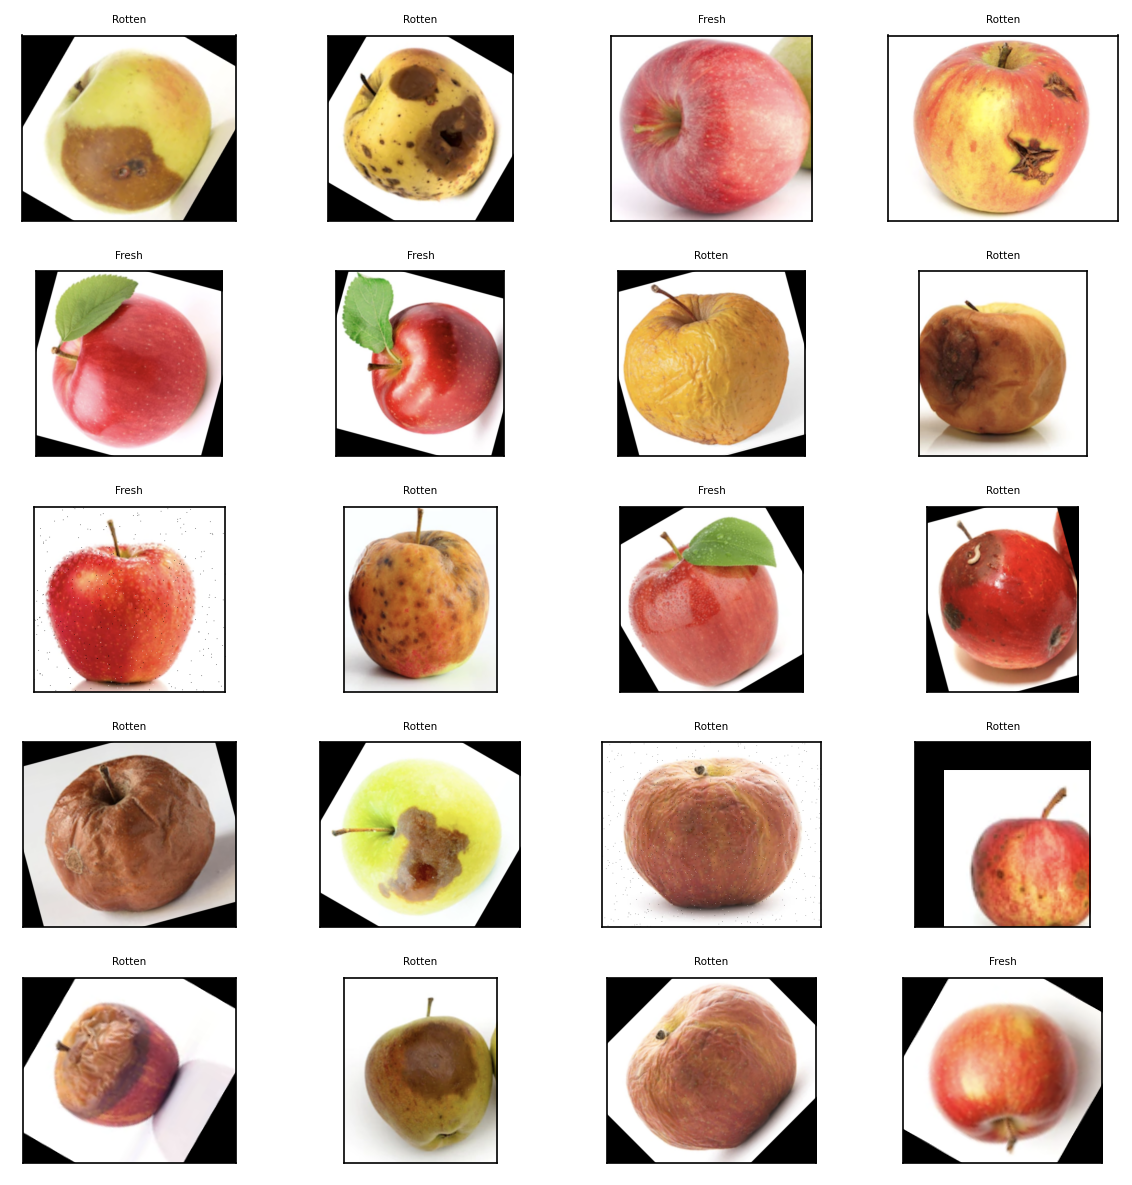

In [12]:
fig = show_data(5,4)
fig.tight_layout()

### Images from test set

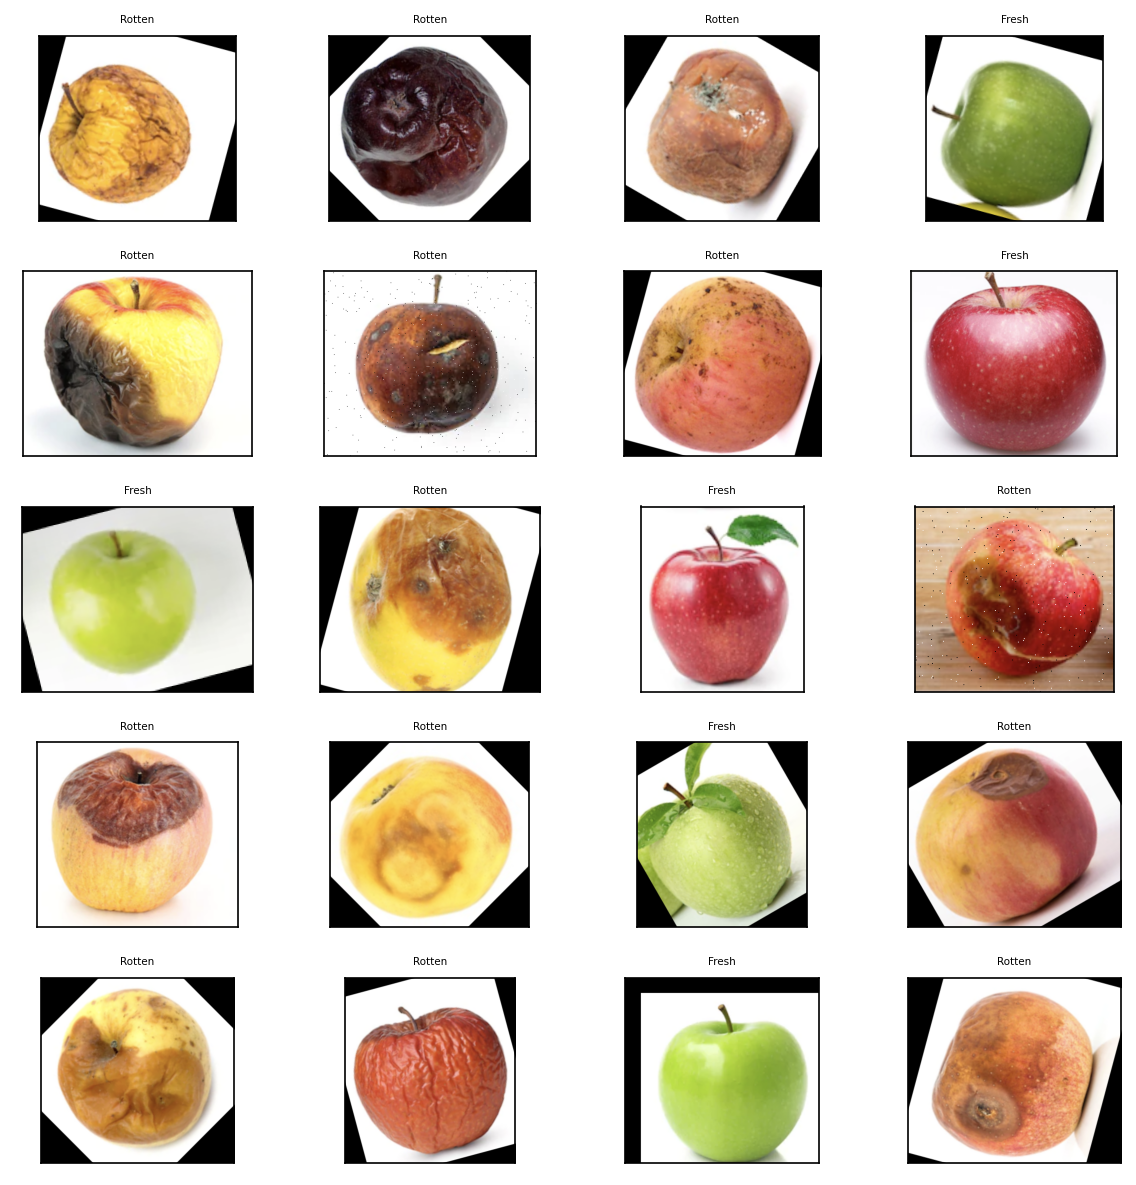

In [13]:
fig = show_data(5,4,is_train=False)
fig.tight_layout()

## Custom Dataset

#### torch.utils.data.Dataset is an abstract class representing a dataset. The custom dataset should inherit Dataset and override the following methods:

1.  __len__ so that len(dataset) returns the size of the dataset.
2.  __getitem__ to support the indexing such that dataset[i] can be used to get ith sample

#### So, I'll be creating a custom dataset FruitsDataset which inherits Dataset class and overrides the above methods.

In [82]:
class AppleDataset(Dataset): # pass dataset as argument
    # constructor
    def __init__(self,path,classifier_type='Rotten',subset='train',transforms=None):
        self.subset = subset
        if self.subset == 'train':
            self.PATH = os.path.join(path,'train','*','*.png')
        elif self.subset == 'test':
            self.PATH = os.path.join(path,'test','*','*.png')
            
        self.data = glob.glob(self.PATH)
        self.height = 32
        self.width = 32
        self.labels = [] 
        
        if classifier_type == 'Rotten':
            classes = ['fresh','rotten']
            for fruit in self.data:
                if classes[0] in fruit.split('/')[-1]:
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        else:
            classes = ['apple','banana','orange']
            for fruit in self.data:
                if classes[0] in fruit:
                    self.labels.append(0)
                elif classes[1] in fruit:
                    self.labels.append(1)
                else:
                    self.labels.append(2)
        self.transforms = transforms
      
    def __getitem__(self,index):
        img_path = self.data[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(self.width,self.height))
        label = self.labels[index]
        if self.transforms is not None:
            img_as_tensor = self.transforms(img)
            if self.transforms is not None:
                return(img_as_tensor,label)
            return(img,label)
  
    def __len__(self):
        return(len(self.data))

## Transformation

One issue we can face is the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some prepocessing code. Let’s create two transforms:

ToTensor: to convert the numpy images to torch images (we need to swap axes).

Normalize: so that the images have zero mean and one variance.

#### Please Note: For rescaling the images to 128x128 size(This is the size I have chosen) I have used cv2. Instead, we can simply use Rescale() transform

In [83]:
transformations = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.7321, 0.6322, 0.5291),
                                                           (0.3302, 0.3432, 0.3701))
                                     ])
dataset = AppleDataset('C:/Users/Shibbs/Desktop/Praxis/AAB_HCA/Assignments/Rotten_Apple_Detection/Datasets/',transforms = transformations)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


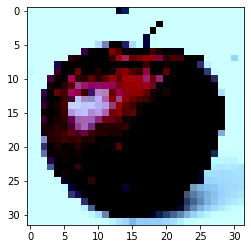

In [84]:
img_t, _ = dataset[1000]
img = img_t.permute(1,2,0)
plt.imshow(img);

## DataLoaders

We can iterate over the created dataset with a simple for loop. However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

Batching the data

Shuffling the data

Load the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features.
I will create separate loaders for training and validation with sampling.

In [85]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

## Training the Model
Let's redifine the nn.Module class to create our custom NN.

In [86]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Lets check the number of parameters we have to train.



In [87]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Confirm if we are training on GPU.

In [88]:
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [89]:
torch.cuda.is_available()

True

In [90]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [92]:
def training_loop(n_epochs,optimizer,model,loss_fn,train_loader):
    for epoch in tqdm_notebook(range(1,n_epochs+1)):
        
        loss_train = 0.0
        
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device) # push to gpu
            labels = labels.to(device=device) # push to gpu
            outputs = model(imgs) # prediction
            loss = loss_fn(outputs,labels)
            #get rid of gradients from last round
            optimizer.zero_grad()
            #performs backward step. Computes all the gradients
            loss.backward()
            #Updates the model
            optimizer.step()
            loss_train += loss.item()
        print('{} Epoch {}, Training Loop {}'.format(
          datetime.datetime.now(), epoch, loss_train/len(train_loader)))

model = Net().to(device=device) #was talking about this above
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
  n_epochs = 50,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)

  0%|          | 0/50 [00:00<?, ?it/s]

2022-04-19 23:06:49.355429 Epoch 1, Training Loop 0.6827795856139239
2022-04-19 23:06:57.755272 Epoch 2, Training Loop 0.6657078371328466
2022-04-19 23:07:06.067397 Epoch 3, Training Loop 0.6566454359129363
2022-04-19 23:07:14.365293 Epoch 4, Training Loop 0.6466724860901926
2022-04-19 23:07:22.658955 Epoch 5, Training Loop 0.6338805719917896
2022-04-19 23:07:30.949078 Epoch 6, Training Loop 0.6168099735297409
2022-04-19 23:07:39.254459 Epoch 7, Training Loop 0.5953310342396007
2022-04-19 23:07:47.548622 Epoch 8, Training Loop 0.5673648136503556
2022-04-19 23:07:55.857807 Epoch 9, Training Loop 0.5335403534711576
2022-04-19 23:08:04.481516 Epoch 10, Training Loop 0.48792832563905153
2022-04-19 23:08:12.945517 Epoch 11, Training Loop 0.4340934075561224
2022-04-19 23:08:21.426915 Epoch 12, Training Loop 0.3741820705871956
2022-04-19 23:08:30.087850 Epoch 13, Training Loop 0.32548990933334127
2022-04-19 23:08:38.620411 Epoch 14, Training Loop 0.28717446444081324
2022-04-19 23:08:47.149166

Save our trained model to be deployed on the site later on.



In [93]:
torch.save(model.state_dict(), 'RottenApple.pt')

## Evaluate model

In [94]:
def validate(model,train_loader,val_loader):
    for name, loader in [('train',train_loader),('val',validation_loader)]:
        correct = 0
        total = 0

        #gradients nor required, as we don't want to train our parameters
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                #max_index,value
                _,predicted = torch.max(outputs,dim=1)
                total+=labels.shape[0]
                correct+=int((predicted==labels).sum())
    
        print('Accuracy {}: {:.2f}'.format(name, correct/total))

validate(model,train_loader,validation_loader)

Accuracy train: 0.96
Accuracy val: 0.96


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: 0
Prediction: tensor([[ 3.3359, -3.3250]], device='cuda:0', grad_fn=<AddmmBackward0>)


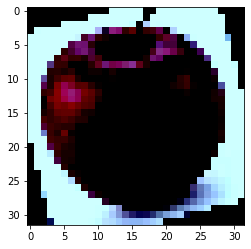

In [97]:
img,label = dataset[65]
plt.imshow(img.permute(1,2,0))
out = model(img.unsqueeze(0).to(device))
print('Actual: {}'.format(label))
print('Prediction: {}'.format(out))

In [99]:
transformations_test = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7369, 0.6360, 0.5318),
                                                           (0.3281, 0.3417, 0.3704))
                                      ])
test = AppleDataset('C:/Users/Shibbs/Desktop/Praxis/AAB_HCA/Assignments/Rotten_Apple_Detection/Datasets/',subset='test',transforms=transformations_test)

In [100]:
imgs = torch.stack([img for img,_ in tqdm_notebook(test)], dim=3)
imgs.shape

#Mean
print(imgs.view(3,-1).mean(dim=1))
#Standard Deviation
print(imgs.view(3, -1).std(dim=1))

  0%|          | 0/996 [00:00<?, ?it/s]

tensor([ 0.0220, -0.0269, -0.0067])
tensor([0.9283, 1.0145, 0.9961])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: tensor([[2.0014e-04, 9.9980e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


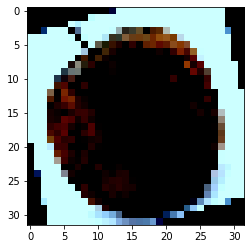

In [101]:
img,_ = test[400]
plt.imshow(img.permute(1,2,0))
s = nn.Softmax(dim=1)
out = s(model(img.unsqueeze(0).to(device)))
print('Prediction: {}'.format(out))

In [102]:
correct = 0
total = 0
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    out = model(imgs)
    _,predicted = torch.max(out,dim=1)
    correct += int((predicted==labels).sum())
    total += len(labels)

## Final Accuracy

In [103]:
(correct/total)*100

96.37546468401487